## **Supplemental daily VI prediction in Jupyter Notebook format using Python v3.10**  
## **to accompany**  
## **CANOPY Phenology Model v0.99 in Jupyter Notebook format using Python v3.10**

Part of the CANOPY phenology model structural development continued in 2022-2024 by:

Matthew Garcia, Ph.D.  
Research Scientist I  
Dept. of Forest & Wildlife Ecology  
University of Wisconsin-Madison  
email: matt.e.garcia@gmail.com

This code is made available under the GNU General Public License (GPL) v3.0. A copy of the GPLv3 is available from the Free Software Foundation at http://www.gnu.org/licenses/gpl.html.

Users are asked to link to this GitHub repository in any derivative and/or published works. Users are expected to reference the attached publication in any derived and/or published works. As of 30 September 2024, the preferred citation is:

> Garcia, M., and P.A. Townsend, 2024 (in prep): "CANOPY: Modeling temperate forest phenology and possible disturbances using Landsat and weather observations." Manuscript in preparation for submission to *MethodsX* with an accompanying paper in *Remote Sensing of Environment*.

---

**This model is oriented on VI prediction on a single-pixel basis.**

This notebook handles the post-modeling procedure for daily VI prediction:
- PLS prediction on a *daily* (instead of image) basis in the analysis and forecast periods

**This notebook requires access to both the input and output of the full phenology model for the analyzed VI.**

**Daily VI predction over the period of the given daily WxCD data is the *sole* function of this notebook.**

**This procedure applies *no* spatial analysis at *any* scale to the model results.**


In [1]:
import platform
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
print('Python package versions')
print(f'    python v. {platform.python_version()}')
print(f'    numpy v. {np.__version__}')
print(f'    pandas v. {pd.__version__}')
print(f'    matplotlib v. {mpl.__version__}')

Python package versions
    python v. 3.10.15
    numpy v. 1.26.4
    pandas v. 2.2.2
    matplotlib v. 3.8.4


In [3]:
print('Post-modeling PLS-based prediction on a daily basis')
print()
#
point_id = '2023-120_CC'
vi_name = 'NDMI'
output_path = f'{point_id}_{vi_name}_analyses'
daily_data_begin_year = 2020
daily_data_end_year = 2023
graph_output = True
#
# get metavals
metavals_fname = f'{point_id}_metavals_{vi_name}_ABC_DOY.csv'
metavals_fpath = f'{output_path}/{metavals_fname}'
metavals_df = pd.read_csv(metavals_fpath, index_col=None, header=None, names=['key', 'value'])
metavals = dict(zip(metavals_df['key'], metavals_df['value']))
curve_str = metavals['vi_curve_str']
x_basis = metavals['x_basis']
growing_season_start = metavals['growing_season_start']
growing_season_end = metavals['growing_season_end']
daily_data_input_path = metavals['input_path']
#
# get daily WxCD data
if daily_data_end_year > daily_data_begin_year:
    daily_data_infname = f'{point_id}_daily_Daymet_data_{daily_data_begin_year}-{daily_data_end_year}.csv'
else:
    daily_data_infname = f'{point_id}_daily_Daymet_data_{daily_data_begin_year}.csv'
    daily_data_end_year = daily_data_begin_year
daily_data_infpath = f'{daily_data_input_path}/{daily_data_infname}'
print(f'reading {daily_data_infname}')
daily_wxcd_all_df = pd.read_csv(daily_data_infpath, index_col=None)
daily_wxcd_all_df.fillna(0.0, inplace=True)
#
# get regression_vars and regression_betas
regression_vars_fname = f'{point_id}_{vi_name}_{curve_str}_{x_basis}_final_PLSR_vars+betas.csv'
regression_vars_fpath = f'{output_path}/{regression_vars_fname}'
print(f'reading {regression_vars_fname}')
regression_vars_df = pd.read_csv(regression_vars_fpath, index_col=None)
regression_vars = list(regression_vars_df['var'])
regression_nvars = len(regression_vars)
regression_betas = np.array(regression_vars_df['beta'])
#
# get full_year_mean_vi
mean_vi_fname = f'{point_id}_{vi_name}_{curve_str}_{x_basis}_final_mean_phenology_full_year.npy'
mean_vi_fpath = f'{output_path}/{mean_vi_fname}'
print(f'reading {mean_vi_fname}')
full_year_mean_vi = np.load(mean_vi_fpath)
#
# get trend_params_df
trend_params_fname = f'{point_id}_{vi_name}_{curve_str}_{x_basis}_final_trend_params.csv'
trend_params_fpath = f'{output_path}/{trend_params_fname}'
print(f'reading {trend_params_fname}')
trend_params_df = pd.read_csv(trend_params_fpath, index_col=None)
#
# get stnd_params_df
stnd_params_fname = f'{point_id}_{vi_name}_{curve_str}_{x_basis}_final_stnd_params.csv'
stnd_params_fpath = f'{output_path}/{stnd_params_fname}'
print(f'reading {stnd_params_fname}')
stnd_params_df = pd.read_csv(stnd_params_fpath, index_col=None)
#
# get all VI observations (wxcd_vi_all_df)
full_dataset_fname = f'{point_id}_input_WxCD_VI_cleaned_trimmed.csv'
full_dataset_fpath = f'{output_path}/{full_dataset_fname}'
print(f'reading {full_dataset_fname}')
wxcd_vi_all_df = pd.read_csv(full_dataset_fpath, index_col=None)
#
# get outlier VI observations (vi_outliers_df)
outliers_fname = f'{point_id}_{vi_name}_{curve_str}_{x_basis}_final_all_outliers.csv'
outliers_fpath = f'{output_path}/{outliers_fname}'
print(f'reading {outliers_fname}')
vi_outliers_df = pd.read_csv(outliers_fpath, index_col=None)
#
print()


Post-modeling PLS-based prediction on a daily basis

reading 2023-120_CC_daily_Daymet_data_2020-2023.csv
reading 2023-120_CC_NDMI_ABC_DOY_final_PLSR_vars+betas.csv
reading 2023-120_CC_NDMI_ABC_DOY_final_mean_phenology_full_year.npy
reading 2023-120_CC_NDMI_ABC_DOY_final_trend_params.csv
reading 2023-120_CC_NDMI_ABC_DOY_final_stnd_params.csv
reading 2023-120_CC_input_WxCD_VI_cleaned_trimmed.csv
reading 2023-120_CC_NDMI_ABC_DOY_final_all_outliers.csv



In [4]:
# part of phenology_model_stats.py
#

def standardize_given_stats(y, y_stats):
    y_mean, y_std = y_stats
    if y_std:
        standardized_y = (y - y_mean) / y_std
    else:
        standardized_y = np.zeros_like(y)
    #
    return standardized_y


def destandardize(standardized_y, y_stats):
    y_mean, y_std = y_stats
    y = (standardized_y * y_std) + y_mean
    #
    return y


def detrend_given_stats(x, y, r_params):
    slope, intercept = r_params[:2]
    detrended_y = y - (slope * x + intercept)
    #
    return detrended_y


def retrend(x, detrended_y, r_params):
    slope, intercept = r_params[:2]
    y = detrended_y + (slope * x + intercept)
    #
    return y

#
# end part of phenology_model_stats.py

wrote 2023-120_CC_NDMI_ABC_DOY_daily_PLS_prediction_2020.csv
saved 2023-120_CC_NDMI_ABC_DOY_daily_PLS_prediction_2020.png
wrote 2023-120_CC_NDMI_ABC_DOY_daily_PLS_prediction_2021.csv
saved 2023-120_CC_NDMI_ABC_DOY_daily_PLS_prediction_2021.png
wrote 2023-120_CC_NDMI_ABC_DOY_daily_PLS_prediction_2022.csv
saved 2023-120_CC_NDMI_ABC_DOY_daily_PLS_prediction_2022.png
wrote 2023-120_CC_NDMI_ABC_DOY_daily_PLS_prediction_2023.csv
saved 2023-120_CC_NDMI_ABC_DOY_daily_PLS_prediction_2023.png



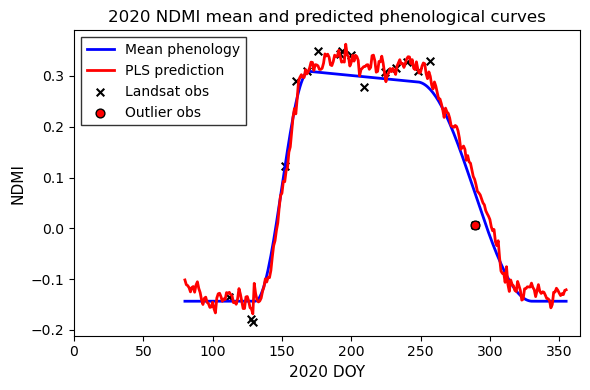

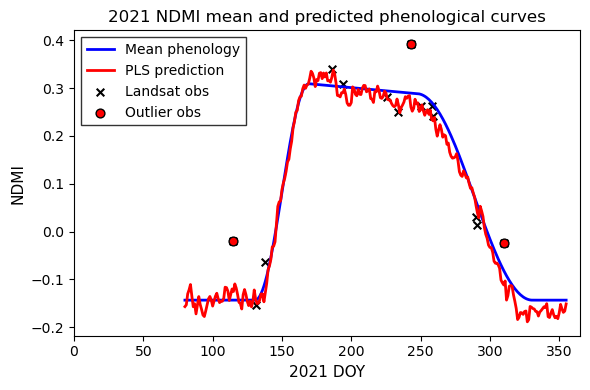

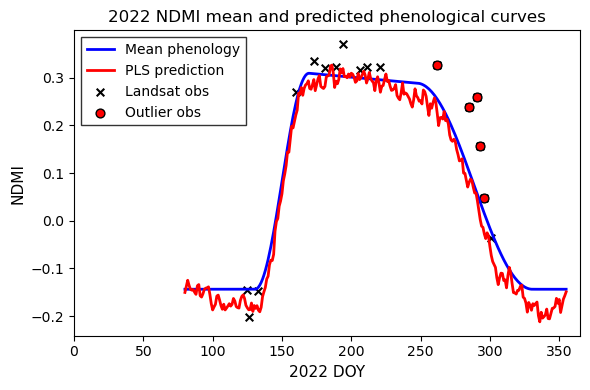

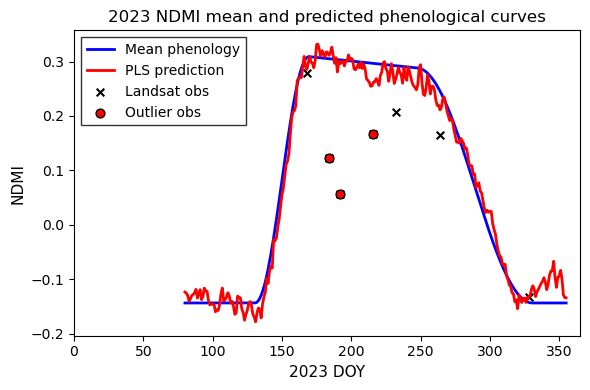

In [5]:
#
# loop through years of available daily WxCD data
for year in range(daily_data_begin_year, daily_data_end_year+1):
    #
    # isolate this year's daily WxCD data
    daily_wxcd_df = daily_wxcd_all_df[daily_wxcd_all_df['Year'] == year]
    year_years = np.array(daily_wxcd_df['Year'])
    year_doys = np.array(daily_wxcd_df['DOY'])
    year_dyears = year_years + (year_doys / 366)
    daily_pls_prediction_df = pd.DataFrame({'Year': year_years, 'DOY': year_doys, 'DYear': year_dyears})
    #
    # isolate just the required WxCD variables
    for var_name in regression_vars:
        var_std_anoms = np.array(daily_wxcd_df[var_name])
        daily_pls_prediction_df[var_name] = var_std_anoms
    #
    # add mean phenology curve values according to DOY
    year_vi_mean = [full_year_mean_vi[doy-1] for doy in year_doys]
    daily_pls_prediction_df[f'{vi_name}_fitted'] = year_vi_mean
    #
    #
    regression_wxcd_detrended_stnd = np.zeros((len(year_doys), regression_nvars))
    for n, var_name in enumerate(regression_vars):
        var_values = np.array(daily_wxcd_df[var_name])
        var_trend_params = np.array(trend_params_df[var_name][:2])
        var_detrended = detrend_given_stats(year_dyears, var_values, var_trend_params)
        var_stnd_params = np.array(stnd_params_df[f'{var_name}_detrended'])
        var_detrended_stnd = standardize_given_stats(var_detrended, var_stnd_params)
        regression_wxcd_detrended_stnd[:, n] = var_detrended_stnd
        daily_pls_prediction_df[f'{var_name}_detrended_stnd'] = var_detrended_stnd
    #
    # calculate predicted VI residuals
    predicted_vi_residuals_detrended_stnd = np.dot(regression_wxcd_detrended_stnd, regression_betas)
    #
    # destandardize + retrend predicted VI residuals
    vi_residual_stnd_params = np.array(stnd_params_df[f'{vi_name}_residual_detrended'])
    predicted_vi_residuals_detrended = \
        destandardize(predicted_vi_residuals_detrended_stnd, vi_residual_stnd_params)
    vi_residual_trend_params = np.array(trend_params_df[f'{vi_name}_residual'][:2])
    predicted_vi_residuals = \
        retrend(year_dyears, predicted_vi_residuals_detrended, vi_residual_trend_params)
    daily_pls_prediction_df[f'{vi_name}_residual_predicted'] = predicted_vi_residuals
    predicted_vi_values = predicted_vi_residuals + year_vi_mean
    daily_pls_prediction_df[f'{vi_name}_predicted'] = predicted_vi_values
    #
    outfname = f'{point_id}_{vi_name}_{curve_str}_{x_basis}_daily_PLS_prediction_{year}.csv'
    outfpath = f'{output_path}/{outfname}'
    daily_pls_prediction_df.to_csv(outfpath, index=False)
    print(f'wrote {outfname}')
    #
    # get VI observations for this year
    wxcd_vi_year_df = wxcd_vi_all_df[wxcd_vi_all_df['Year'] == year]
    observed_doys = list(wxcd_vi_year_df['DOY'])
    observed_vi_values = list(wxcd_vi_year_df[vi_name])
    #
    # get outlier VI observations for this year
    vi_outliers_year_df = vi_outliers_df[vi_outliers_df['Year'] == year]
    if len(vi_outliers_df):
        outliers = True
        outliers_doys = list(vi_outliers_year_df['DOY'])
        outliers_vi_values = list(vi_outliers_year_df[vi_name])
    #
    # plot daily predicted VI values with observed Landsat VI values
    if graph_output:
        plt.figure(figsize=(6, 4))
        plt.plot(year_doys, year_vi_mean, 'b-', linewidth=2, label='Mean phenology')
        plt.plot(year_doys, predicted_vi_values, 'r-', linewidth=2, label='PLS prediction')
        plt.scatter(observed_doys, observed_vi_values, marker='x', c='k', s=30, label='Landsat obs')
        if outliers:
            plt.scatter(outliers_doys, outliers_vi_values, marker='o', c='r', edgecolor='k', s=40,
                        label=f'Outlier obs')
        plt.legend(loc='upper left', fancybox=False, edgecolor='k')
        plt.xlim([0, 365])
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        plt.xlabel(f'{year} DOY', fontsize=11)
        plt.ylabel(vi_name, fontsize=11)
        plt.title(f'{year} {vi_name} mean and predicted phenological curves', fontsize=12)
        plt.tight_layout()
        plotfname = f'{point_id}_{vi_name}_{curve_str}_{x_basis}_daily_PLS_prediction_{year}.png'
        plotfpath = f'{output_path}/{plotfname}'
        plt.savefig(plotfpath, dpi=300, bbox_inches='tight')
        print(f'saved {plotfname}')
#
print()



## **End of Supplemental daily VI prediction in Jupyter notebook format using Python v3.10**
